# TED Youtube API Analysis 

## 1. Introduction 

According to datareportal, based on its global advertising audience reach numbers, as of January 2023, YouTube has at least 2.514 billion users from all around the world. The platform provides contents in so many ranges such as entertainment, education, lifestyles, technology to name a few. As a user, I found myself filling up my free time by watching YouTube videos from various content creators. There are so many popular channels to choose from that can cater your interest. Personally, I always liked to watch vlogs, gameplay videos, tech reviews and watching TED lectures online. 

The TED conference is an American-Canadian non-profit media organization that posts international talks online for free distribution under the slogan "Ideas worth spreading". It was founded by Richard Saul Wurman and Harry Marks in February 1984 as a tech conference, in which Mickey Schulhof gave a demo of the compact disc that was invented in October 1982. The conference has been held annually since 1990. TED covers almost all topics ranging from science to business to global issues. To date, more than 13,000 TEDx events have been held in at least 150 countries.(Source: Wikipedia)

### 1.1 - Objective
The objective of this project is to analyze the TED YouTube data by implementing API scraping technique on the YouTube Data API. I'll extract the data and then load it into a pandas dataframe so that further analysis can be done. Finally, a simple visualization using seaborn library will also be made to present the insights gathered by performing an exploratory analysis on the data.

### 1.2 - Import Libraries
- The google-api-python-client method is imported prior to this project so that I can make the API call.
- Pandas is use to build the dataframes, performing analytical tasks on the dataframes.
- Seaborn is a visualization libraries that are build on matplotlib and is used to visualize insights.
- NLP for human language processing in order to generate a wordcloud of the videos' titles.

In [1]:
# import libraries
from googleapiclient.discovery import build
import re
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

## 2. Data Acquisition

### 2.1 - Data Needs
To undergo the analysis, the following data are needed:

- TED YouTube channel statistics such as number of subscribers, number of total views, number of total videos. 
- The playlist id that locate the playlist that contains all of the uploaded videos.
- Videos id, to get the statistics of each uploaded videos such that, the views, like count, comment count, duration of the video, upload date and also its title.

### 2.2 - Data Sources (API Key)
This project started by first creating a YouTube API Key which will be our credential to access the YouTube data. Once the API Key is generated, the documentation prepared by google is skeemed over to learn how to use the API Key in order to access different YouTube data.

One more important key is the TED YouTube channel id that can be obtained from YouTube itself.

In [2]:
# keys
api_key = "XXX"
channel_id = "XXX"

In [3]:
# api calls
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=api_key)

#### Function to Fetch The TED Channel Data

In [4]:
def get_channel_stats(youtube, channel_id):
    
    all_data = []
    
    request = youtube.channels().list(
                part = "snippet,contentDetails,statistics",
                id = channel_id)
    
    response = request.execute()
    
    # loop through items
    for item in response['items']:
        data = {'channel_name': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'video_count':item['statistics']['videoCount'],
                'playlist_id': item['contentDetails']['relatedPlaylists']['uploads']}
        
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

#### Function to Fetch The Videos ID 

In [5]:
playlist_id = "XXX"

def get_video_id(youtube, playlist_id):
    
    video_ids = []

    request = youtube.playlistItems().list(
                    part = "contentDetails",
                    playlistId = playlist_id,
                    maxResults = 50)

    response = request.execute()
    
    # loop through items
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part = "contentDetails",
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)

            response = request.execute()
    
            # loop through items
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
    
    return video_ids

In [6]:
video_ids = get_video_id(youtube, playlist_id)
len(video_ids)

4268

#### Function to Fetch The Videos Statistics

In [7]:
def get_video_details(youtube, video_ids):

    all_data_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part = "snippet,contentDetails,statistics",
                    id = ','.join(video_ids[i:i+50]))

        response = request.execute()
        
        # loop through items
        for video in response['items']:
            video_stats = {'snippet': ['channelTitle', 'title', 'publishedAt'],
                           'statistics': ['viewCount', 'likeCount', 'commentCount'],
                           'contentDetails': ['duration']
                           }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in video_stats.keys():
                for v in video_stats[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_data_stats.append(video_info)
            
    return pd.DataFrame(all_data_stats)

## 3. Methodology

### 3.1 - Data Loading
First, the TED channel data were load into a Pandas DataFrame called **channel_data**, resulting in a table with 5 columns consisting of the channel name, total views count, subscribers count, videos count and playlist id.

Next, the statistics of all of the uploaded videos were load into a Pandas DataFrame called **stats_data**, giving us the information of the videos' title, upload date, video duration, views, like count and comment count. 

In [8]:
channel_data = get_channel_stats(youtube, channel_id)
channel_data

,channel_name,subscribers,views,video_count,playlist_id
0,TED,22700000,2496313833,4268,UUAuUUnT6oDeKwE6v1NGQxug


In [9]:
stats_data = get_video_details(youtube, video_ids)
stats_data

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration
0,7HKOwDtsuWk,TED,How to boost your brain and memory with Lisa G...,2023-03-24T18:26:30Z,7038,234,28,PT2M12S
1,qVjm9YpZf-c,TED,Rethinking Memory,2023-03-24T18:19:45Z,2,0,0,PT2M23S
2,NO0RF3FNQBU,TED,Stay Engaged,2023-03-24T18:18:23Z,2,0,0,PT1M50S
3,9JUtai1aFc8,TED,Memory Palace,2023-03-24T18:17:53Z,2,0,0,PT1M46S
4,IPSGrREzG-w,TED,Normal Forgetting,2023-03-24T18:17:31Z,2,0,0,PT4M51S
...,...,...,...,...,...,...,...,...
4263,iG9CE55wbtY,TED,Do schools kill creativity? | Sir Ken Robinson,2007-01-07T05:00:34Z,22256726,266913,12032,PT20M4S
4264,gQ-cZRmHfs4,TED,Majora Carter: Greening the ghetto | TED,2007-01-07T04:18:33Z,191406,1979,92,PT19M16S
4265,RTIY66IPjdY,TED,Dean Ornish: The world's killer diet,2007-01-06T23:47:40Z,118389,821,94,PT3M35S
4266,Y6bbMQXQ180,TED,"Secrets of success in 8 words, 3 minutes | Ric...",2007-01-06T19:53:49Z,3239583,49247,728,PT3M47S


### 3.2 - Data Pre-processing / Data Cleaning

#### 3.2.1 - Checking for Null Values & Data Types
- Checking for null values is good practice. For this project, drop if any.
- The data types of the data are object and we need to convert the count data into int using *pd.to_numeric* method.
- Convert the upload date datatype from object into datetime. 
- Convert the video duration datatype into seconds using the isodate libraries. (source: stackoverflow)

In [10]:
stats_data.isnull().any()

video_id        False
channelTitle    False
title           False
publishedAt     False
viewCount       False
likeCount        True
commentCount     True
duration        False
dtype: bool

In [11]:
stats_data['likeCount'].isnull().sum()

81

In [12]:
stats_data['commentCount'].isnull().sum()

52

In [13]:
stats_data.dropna(how='any',axis=0,inplace=True)

In [14]:
stats_data.isnull().any()

video_id        False
channelTitle    False
title           False
publishedAt     False
viewCount       False
likeCount       False
commentCount    False
duration        False
dtype: bool

In [15]:
stats_data.dtypes

video_id        object
channelTitle    object
title           object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
dtype: object

In [16]:
# convert the numeric data
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
stats_data[numeric_cols] = stats_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

# upload date
stats_data['publishedAt'] = pd.to_datetime(stats_data['publishedAt']).dt.date 
stats_data['month'] = pd.to_datetime(stats_data['publishedAt']).dt.strftime('%b')

# convert duration to seconds
import isodate
stats_data['duration_by_secs'] = stats_data['duration'].apply(lambda x: isodate.parse_duration(x))
stats_data['duration_by_secs'] = stats_data['duration_by_secs'].astype('timedelta64[s]')

In [17]:
stats_data.head()

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,month,duration_by_secs
0,7HKOwDtsuWk,TED,How to boost your brain and memory with Lisa G...,2023-03-24,7038,234,28,PT2M12S,Mar,132.0
1,qVjm9YpZf-c,TED,Rethinking Memory,2023-03-24,2,0,0,PT2M23S,Mar,143.0
2,NO0RF3FNQBU,TED,Stay Engaged,2023-03-24,2,0,0,PT1M50S,Mar,110.0
3,9JUtai1aFc8,TED,Memory Palace,2023-03-24,2,0,0,PT1M46S,Mar,106.0
4,IPSGrREzG-w,TED,Normal Forgetting,2023-03-24,2,0,0,PT4M51S,Mar,291.0


#### 3.2.2 - Checkpoint
Verify the dataset looks good. Save it out to csv locally.

In [18]:
# convert the numeric data
channel_data['subscribers'] = pd.to_numeric(channel_data['subscribers'])
channel_data['views'] = pd.to_numeric(channel_data['views'])
channel_data['video_count'] = pd.to_numeric(channel_data['video_count'])

channel_data.dtypes

channel_name    object
subscribers      int64
views            int64
video_count      int64
playlist_id     object
dtype: object

In [19]:
stats_data.dtypes

video_id             object
channelTitle         object
title                object
publishedAt          object
viewCount             int64
likeCount             int64
commentCount          int64
duration             object
month                object
duration_by_secs    float64
dtype: object

In [45]:
#channel_data.to_csv('ted_youtube_channel_data.csv')
#stats_data.to_csv('ted_youtube_stats_data.csv')

### 3.3 - Data Exploration & Visualization

In [21]:
print("Average view count:",stats_data.viewCount.mean())
print("Maximum view count:",stats_data.viewCount.max())
print("Minimum view count:",stats_data.viewCount.min())

Average view count: 582764.655729795
Maximum view count: 52033010
Minimum view count: 0


In [22]:
print("Average like count:",stats_data.likeCount.mean())
print("Maximum like count:",stats_data.likeCount.max())
print("Minimum like count:",stats_data.likeCount.min())

Average like count: 11478.710735826297
Maximum like count: 1827756
Minimum like count: 0


In [23]:
print("Average comment count:",stats_data.commentCount.mean())
print("Maximum comment count:",stats_data.commentCount.max())
print("Minimum comment count:",stats_data.commentCount.min())

Average comment count: 809.5587454764777
Maximum comment count: 128235
Minimum comment count: 0


In [24]:
print("Average duration by secs:",stats_data.duration_by_secs.mean())
print("Maximum duration by secs:",stats_data.duration_by_secs.max())
print("Minimum duration by secs:",stats_data.duration_by_secs.min())

Average duration by secs: 783.2610373944511
Maximum duration by secs: 9317.0
Minimum duration by secs: 0.0


#### 3.3.1 - The Views Distribution per Videos

<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

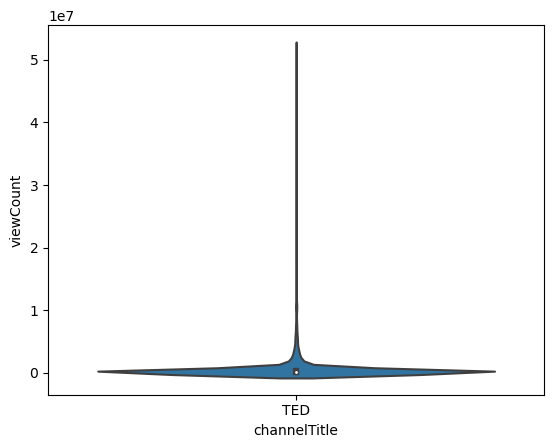

In [25]:
sns.violinplot(stats_data['channelTitle'], stats_data['viewCount'])

#### 3.3.2 - The Best Performing TED Videos

In [26]:
Top10 = stats_data.sort_values('viewCount', ascending=False).head(10)
Top10

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,month,duration_by_secs
2171,arj7oStGLkU,TED,Tim Urban: Inside the mind of a master procras...,2016-04-06,52033010,1827756,78201,PT14M4S,Apr,844.0
2431,6Af6b_wyiwI,TED,Bill Gates: The next outbreak? We’re not ready...,2015-04-03,37135023,739422,128235,PT8M37S,Apr,517.0
2606,eIho2S0ZahI,TED,How to speak so that people want to listen | J...,2014-06-27,36747125,740490,10247,PT9M59S,Jun,599.0
2833,DFjIi2hxxf0,TED,Tom Thum: The orchestra in my mouth | TED,2013-07-19,34310009,776147,19809,PT11M42S,Jul,702.0
2963,KM4Xe6Dlp0Y,TED,"Looks aren't everything. Believe me, I'm a mod...",2013-01-16,29180782,498657,25717,PT9M38S,Jan,578.0
2804,GZGY0wPAnus,TED,The art of misdirection | Apollo Robbins,2013-09-13,25879223,518044,12835,PT8M48S,Sep,528.0
1911,zIwLWfaAg-8,TED,Elon Musk: The future we're building -- and bo...,2017-05-03,25130968,379051,25806,PT40M51S,May,2451.0
2221,8KkKuTCFvzI,TED,Robert Waldinger: What makes a good life? Less...,2016-01-25,23957512,452141,11234,PT12M47S,Jan,767.0
3062,xYemnKEKx0c,TED,Strange answers to the psychopath test | Jon R...,2012-08-15,23759818,461798,23810,PT18M2S,Aug,1082.0
3033,Ks-_Mh1QhMc,TED,Your body language may shape who you are | Amy...,2012-10-01,22929007,383547,9482,PT21M3S,Oct,1263.0


<AxesSubplot:xlabel='viewCount', ylabel='title'>

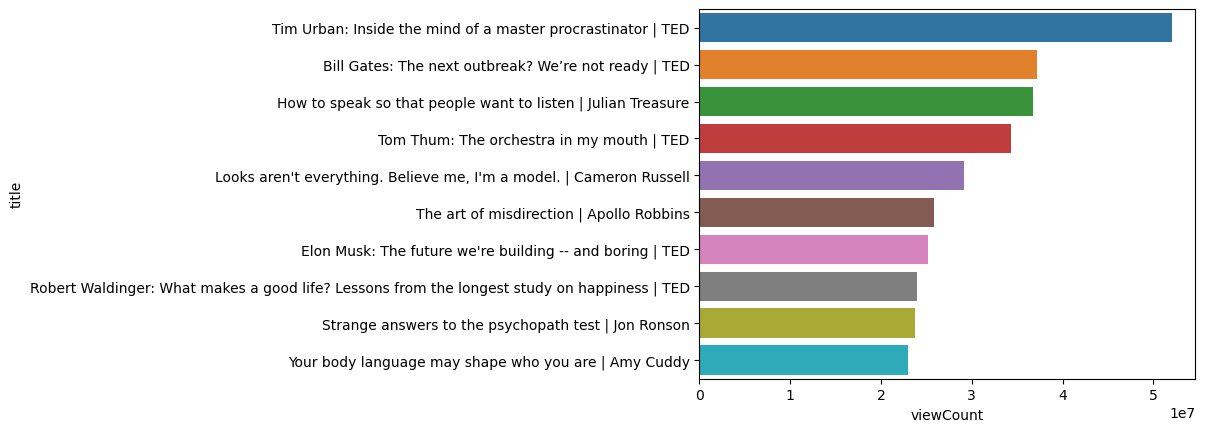

In [27]:
sns.barplot(data=Top10, y="title", x="viewCount")

#### 3.3.3 - The Worst Performing TED Videos

In [28]:
Worst10 = stats_data.sort_values('viewCount', ascending=True).head(10)
Worst10

,video_id,channelTitle,title,publishedAt,viewCount,likeCount,commentCount,duration,month,duration_by_secs
1830,ReptkXNNiLs,TED,TED Live Stream,2017-08-23,0,3,0,P0D,Aug,0.0
14,maiUkj7SPfM,TED,Brain Healthy Food,2023-03-24,2,0,0,PT2M52S,Mar,172.0
13,Hlgi_ndLV7o,TED,Semantic Memory,2023-03-24,2,0,0,PT1M36S,Mar,96.0
12,slqTUB0_2OE,TED,Attach Meaning,2023-03-24,2,0,0,PT2M21S,Mar,141.0
10,NlBjAYFEVOA,TED,Make It Personal,2023-03-24,2,0,0,PT1M21S,Mar,81.0
9,8NYnJ8JAnM4,TED,Manage Stress,2023-03-24,2,0,0,PT3M7S,Mar,187.0
8,lEZnkB-5Rns,TED,Muscle Memory,2023-03-24,2,0,0,PT3M4S,Mar,184.0
11,qVTUaeul2xE,TED,Episodic Memory,2023-03-24,2,0,0,PT7M38S,Mar,458.0
6,g8fu3XdIEVA,TED,Context Matters,2023-03-24,2,0,0,PT2M52S,Mar,172.0
5,euoddu_Uqac,TED,Sleep,2023-03-24,2,0,0,PT2M30S,Mar,150.0


#### 3.3.4 - Views vs. Likes & Comments

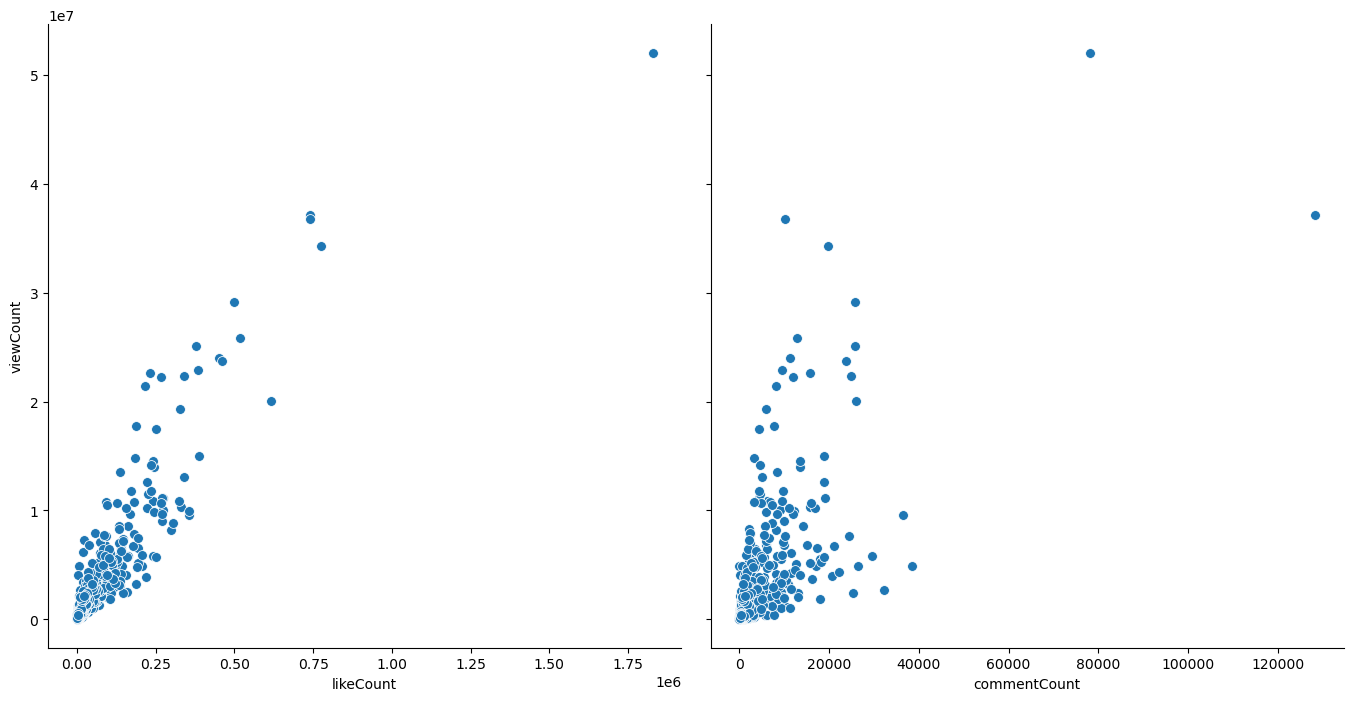

In [30]:
g = sns.PairGrid(stats_data, y_vars=["viewCount"], x_vars=["likeCount", "commentCount"], height=7)
g.map(sns.scatterplot, s=50)

#### 3.3.5 - Video Duration

<AxesSubplot:xlabel='duration_by_secs', ylabel='Count'>

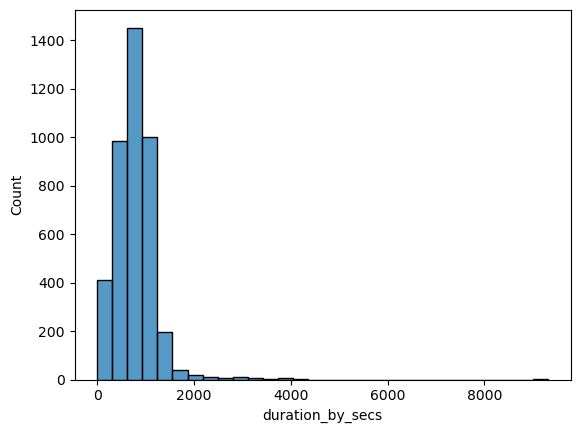

In [31]:
sns.histplot(data=stats_data, x="duration_by_secs", bins=30)

#### 3.3.6 - Views vs. Video Duration

<AxesSubplot:xlabel='duration_by_secs', ylabel='viewCount'>

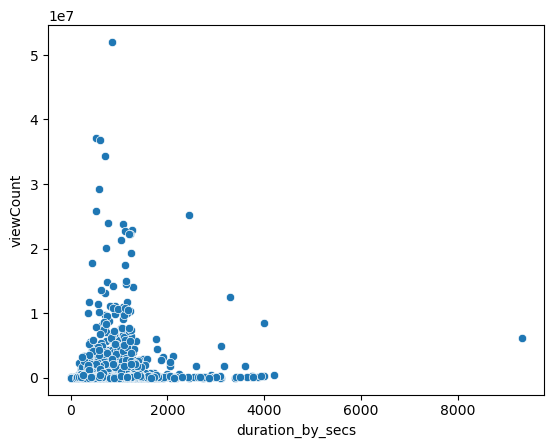

In [32]:
sns.scatterplot(data=stats_data, x="duration_by_secs", y="viewCount")

#### 3.3.7 - Video Uploads per Month

In [33]:
# group data by month
videos_per_month = stats_data.groupby('month', as_index=False).size()
videos_per_month

,month,size
0,Apr,356
1,Aug,246
2,Dec,281
3,Feb,363
4,Jan,391
5,Jul,362
6,Jun,328
7,Mar,371
8,May,364
9,Nov,372


In [34]:
# sort index
sort_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

videos_per_month.index = pd.CategoricalIndex(videos_per_month['month'], categories=sort_order, ordered=True)
videos_per_month = videos_per_month.sort_index()

<AxesSubplot:xlabel='month', ylabel='size'>

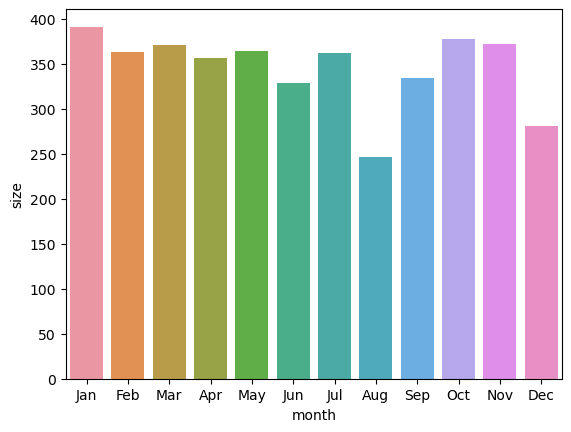

In [35]:
sns.barplot(data=videos_per_month, x="month", y="size")

#### 3.3.9 - Wordcloud for Video Title

In [36]:
# prepare the data
stats_data['title'] = stats_data['title'].astype(str)
stats_data['title'] = stats_data['title'].str.lower()
stats_data['title'] = stats_data['title'].str.replace(r'[-./|?!,":;()\']',' ').str.replace('#',' ').str.replace('@',' ')

In [37]:
stats_data['title']

0       how to boost your brain and memory with lisa g...
1                                       rethinking memory
2                                            stay engaged
3                                           memory palace
4                                       normal forgetting
                              ...                        
4263       do schools kill creativity    sir ken robinson
4264             majora carter  greening the ghetto   ted
4265                 dean ornish  the world s killer diet
4266    secrets of success in 8 words  3 minutes   ric...
4267                 if i controlled the internet   rives
Name: title, Length: 4145, dtype: object

In [38]:
stopword_list = stopwords.words('english')
stopword_list = stopword_list+['ted']+['tedx']+['shorts']+['tedxtalk']+['to']+['s']+['way']+['next']+['make']+['new']

In [39]:
pat = r'\b(?:{})\b'.format('|'.join(stopword_list))
pat

"\\b(?:i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't|ted|tedx|shorts|tedxtalk|to|s|way|next|make|new)\\b"

In [40]:
stats_data['title_new'] = stats_data['title'].str.replace(pat,' ')
stats_data['title_new']

0                    boost   brain   memory   lisa genova
1                                       rethinking memory
2                                            stay engaged
3                                           memory palace
4                                       normal forgetting
                              ...                        
4263          schools kill creativity    sir ken robinson
4264                 majora carter  greening   ghetto    
4265                   dean ornish    world   killer diet
4266    secrets   success   8 words  3 minutes   richa...
4267                        controlled   internet   rives
Name: title_new, Length: 4145, dtype: object

In [41]:
stats_data['title_new'] = stats_data['title_new'].apply(lambda x: [item for item in str(x).split() if item not in pat])

In [42]:
all_words = list([a for b in stats_data['title_new'].tolist() for a in b])
all_words_str = ' '.join(all_words) 
new_words = re.sub("[^a-z]"," ",all_words_str)
print(new_words)

boost brain memory lisa genova rethinking memory stay engaged memory palace normal forgetting sleep context matters prospective memory muscle memory manage stress personal episodic memory attach meaning semantic memory brain healthy food pay attention working memory memories made democracy doomed global fight future keep hometown becoming ghost town john paget happens gas stations world goes electric emily grubert recover illness   using stem cells calm anxiety neuroscientist work series   skills every middle school boy needs jerome hunter indigenous perspective humanity  survival earth surprising psychology behind urge break rules paul bloom owns internet future ordinary things search invisible matter shapes universe   elements true fun   catherine price   steps anxiety overload   take back control   step guide setting better boundaries work work series future astronauts eat phnam bagley ethics help better decisions clean energy hub future rebekah shirley video games level learn kris 

(-0.5, 1999.5, 999.5, -0.5)

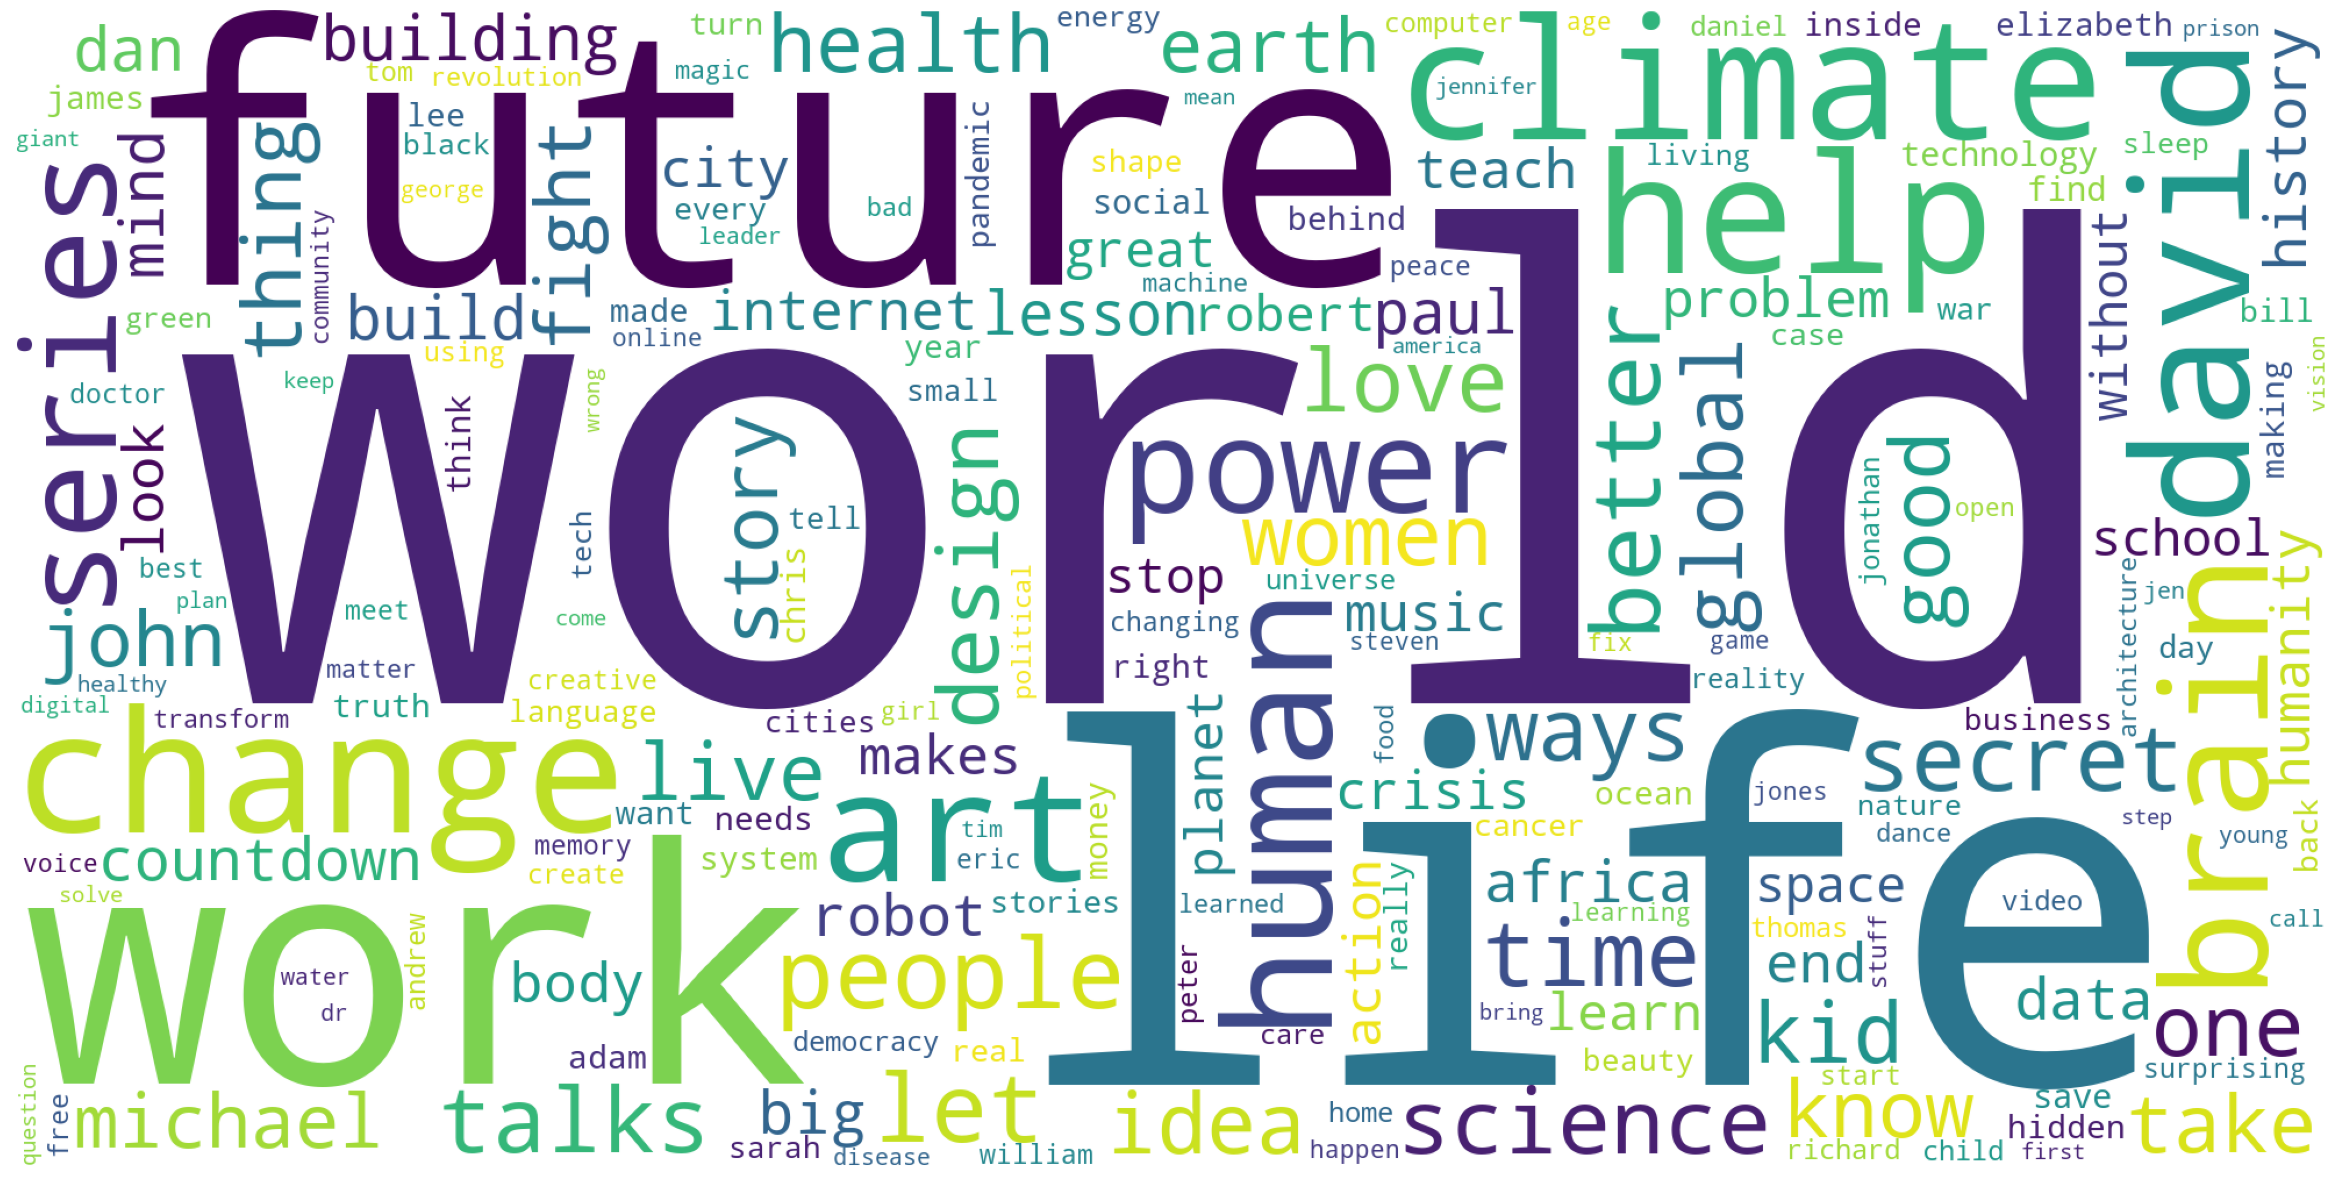

In [44]:
# build the wordcloud
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plt.figure(figsize=(30, 20))
plt.imshow(wordcloud) 
plt.axis("off")

## 4. Discussion

### 4.1 - Analysis & Discussion

***The Views Distribution per Videos***
- The purpose of analysing the views distribution across the videos is so that we can identify massive outliers that affect the average views that the channel have. 
- The violing plot is used as it shows the quantitative data across the categorical variable which is the channel itself.
- From the plot, we can say that although most of TED's videos receive relatively around the same number of views, there are videos that have way more number of views than the rest. 
- This result indicates that, the outliers may affect the average number of views and the next step is to identfy those videos.

***The Best Performing TED Videos***
- Based on the previous analysis, we want to identify the top 10 best performing videos on TED channel. 
- First, we build a pandas dataframe that contains that information. Named the *Top10* dataframe.
- Next, a barplot is used to visualizes the numbers.
- From the plot we can deduce that the best performing videos on TED channel in relation to the number of views is titled "Tim Urban: Inside the mind of a master procrastinator" with over 52 million views.

***The Worst Performing TED Videos***
- For this analysis, the 10 worst performing videos on TED's channel are studied.
- A pandas dataframe that contains the information on the 10 worst performing video is built first.
- From the dataframe we can deduce that the worst performing videos on TED channel in relation to the number of views is titled "TED Live Stream" with the least number of views.

***Views vs. Likes & Comments***
- This analysis used scatter plot to study the relationship between the number of views with likeCount and commentCount. 
- From the plot, it can be said that a video doesn't necessarily have high like and comment count even when it has higher views.

***Video Duration***
- Next, we want to see the distribution of the videos duration.
- A histplot is use to help with the visualization. A histogram is a traditional visualization tool that counts the number of data that fall into discrete bins to illustrate the distribution of one or more variables.
- Histogram divides the entire range of values into a series of intervals called bins. Each bin is plotted as a bar whose height corresponds to how many data points are in that bin.
- For this analysis, we set the bins to be 30. 

***Views vs. Video Duration***
- To better understand the previous analysis, a scatter plot is used to observe relationships between the viewCount and duration_by_secs variables.
- It can be seen that most videos have shorter duration and this helped their views performance, since the long duration videos are having less views.

***Video Uploads per Month***
- In this analysis, the number of videos uploaded each month is studied.
- First, the dataset need to be grouped and sorted by month.
- Thus, the data is group by each month and we can see the size of that data monthly.
- Since python don't know the order of the month, we need to manually sort the order. 
- Then, the index is set categorically based on month.
- A barplot is used to visualize everything, and we can see that more videos were uploaded in Jan while less videos were uploaded in Aug. 

***Wordcloud for Video Title***
- This goal of this analysis is to find the most common keyword from the videos title. Hence, will give us better understanding on which topics were uploaded most frequently. 

## 6. Related Links
- [YouTube Data API](https://developers.google.com/youtube/v3/docs)

***Project References***
- [techTFQ - Blogpost](https://techtfq.com/video/python-project-to-scrape-youtube-using-youtube-data-api)
- [Corey Schafer - YouTube tutorial](https://youtu.be/th5_9woFJmk)
- [StrataScratch - Youtube tutorial](https://youtu.be/fklHBWow8vE)
- [Educational Research Techniques - Youtube Tutorial](https://youtu.be/34yh85mxBfY)
- [Regex Python - Website Tutorial](https://builtin.com/software-engineering-perspectives/python-remove-character-from-string)